In [49]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from scipy.optimize import brentq
from scipy.interpolate import interp1d


In [2]:
# Load datasets
true_df = pd.read_csv("News-_dataset/True.csv")
fake_df = pd.read_csv("News-_dataset/Fake.csv")

# Add labels
true_df['label'] = 1
fake_df['label'] = 0

# Combine and shuffle
df = pd.concat([true_df, fake_df], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [3]:
# Drop nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(subset=["title", "text"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39105 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    39105 non-null  object
 1   text     39105 non-null  object
 2   subject  39105 non-null  object
 3   date     39105 non-null  object
 4   label    39105 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [4]:
# Combine title and text
df['content'] = df['title'] + " " + df['text']
df.drop(columns=["title", "text", "date"], inplace=True)

df.head()

,subject,label,content
0,News,0,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,News,0,Failed GOP Candidates Remembered In Hilarious...
2,News,0,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,politicsNews,1,California AG pledges to defend birth control ...
4,politics,0,AZ RANCHERS Living On US-Mexico Border Destroy...


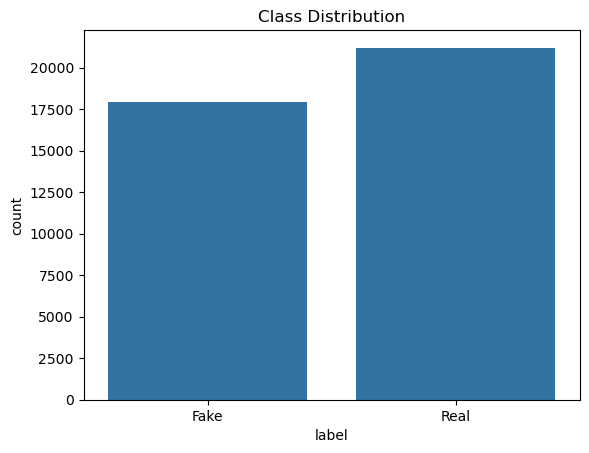

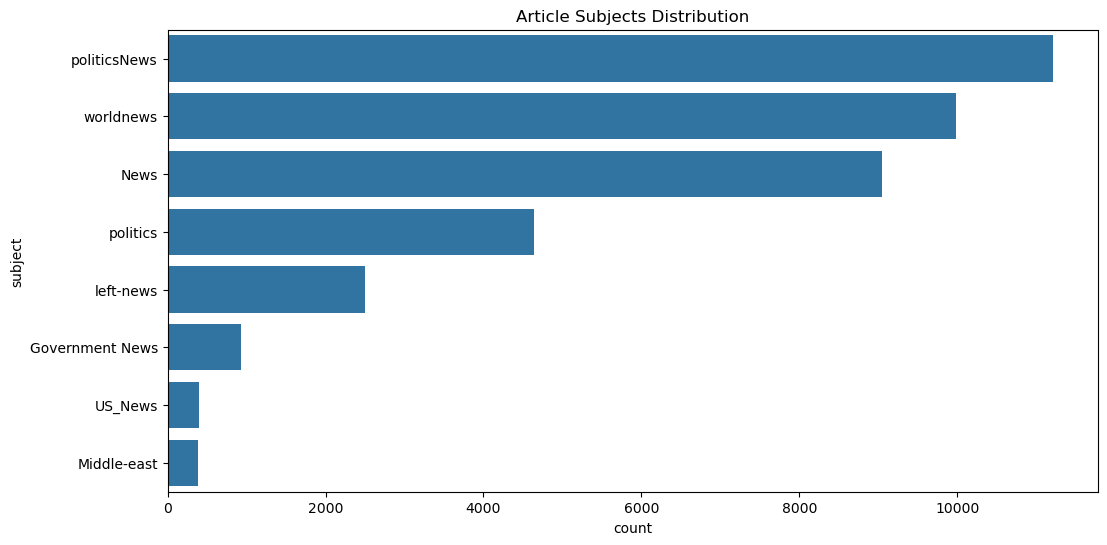

In [5]:
# Class distribution
sns.countplot(data=df, x='label')
plt.title("Class Distribution")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

# Subjects distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index)
plt.title("Article Subjects Distribution")
plt.show()


In [6]:
df_copy = df.copy(deep=True)

In [29]:
df = df_copy.copy(deep=True)
def clean_text(text):
    # Remove "(Reuters) - " and similar patterns *anywhere* in the text
    text = re.sub(r'\b\w+\s+\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)

    # # Remove last sentence if it contains any image-related keywords
    # last_sentence_pattern = r'([^.]*?(images|image|capture|featured|via)[^.]*\.)\s*$'
    # text = re.sub(last_sentence_pattern, '', text, flags=re.IGNORECASE)
    # Remove last sentence if it contains any image-related keywords
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    if sentences:
        last_sentence = sentences[-1]
        if re.search(r'\b(images|image|capture|featured|via)\b', last_sentence, re.IGNORECASE):
            sentences = sentences[:-1]
    text = ' '.join(sentences)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove non-letter characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Lowercase and strip extra spaces
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply to the merged title + text content
df['clean_content'] = df['content'].apply(clean_text)



🔷 Original [32164]:
ization, and passing the proposed TPP,” Navarro and Gray wrote.  “These deals only weaken our manufacturing base and ability to defend ourselves and our allies.” Trump has vowed to pull the United States out of the TPP, a free-trade pact aimed at linking a dozen Pacific Rim nations that President Barack Obama signed in February. It has not been ratified by the U.S. Senate.  The president-elect has also vowed to renegotiate the NAFTA pact with Canada and Mexico, saying it had cost American jobs. 

✅ Cleaned  [32164]:
e world trade organization and passing the proposed tpp navarro and gray wrote these deals only weaken our manufacturing base and ability to defend ourselves and our allies trump has vowed to pull the united states out of the tpp a freetrade pact aimed at linking a dozen pacific rim nations that president barack obama signed in february it has not been ratified by the us senate the presidentelect has also vowed to renegotiate the nafta pact with canada 

/tmp/ipykernel_63429/3313189497.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
/tmp/ipykernel_63429/3313189497.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)


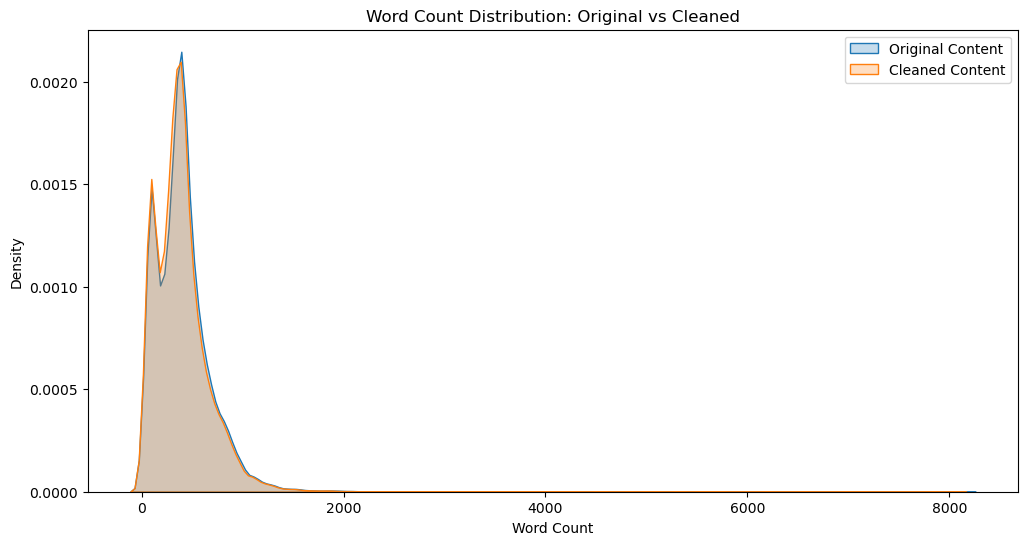

In [30]:
# Show side-by-side comparison of raw vs cleaned content
comparison_df = df[['content', 'clean_content']].sample(50, random_state=42)
for i, row in comparison_df.iterrows():
    # print(f"\n🔷 Original [{i}]:\n{row['content'][:500]}")
    # print(f"\n✅ Cleaned  [{i}]:\n{row['clean_content'][:500]}")
    # print("="*100)
    print(f"\n🔷 Original [{i}]:\n{row['content'][-500:]}")
    print(f"\n✅ Cleaned  [{i}]:\n{row['clean_content'][-500:]}")
    print("="*100)

# Compute length differences
df['raw_len'] = df['content'].apply(lambda x: len(x.split()))
df['clean_len'] = df['clean_content'].apply(lambda x: len(x.split()))
df['reduction'] = df['raw_len'] - df['clean_len']

# Print average reduction
print(f"\n📉 Average word count reduction: {df['reduction'].mean():.2f} words per article")

# Visualize word count distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)
plt.title("Word Count Distribution: Original vs Cleaned")
plt.xlabel("Word Count")
plt.legend()
plt.show()


In [31]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_content'])

sequences = tokenizer.texts_to_sequences(df['clean_content'])
max_len = 500
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values


In [32]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 27373, Val: 7821, Test: 3911


In [58]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/home/ishank/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)

Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - accuracy: 0.7833 - loss: 0.4518 - val_accuracy: 0.7806 - val_loss: 0.3900
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 53s 125ms/step - accuracy: 0.8914 - loss: 0.2673 - val_accuracy: 0.9515 - val_loss: 0.1465
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 54s 126ms/step - accuracy: 0.9446 - loss: 0.1589 - val_accuracy: 0.9669 - val_loss: 0.1284
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 54s 125ms/step - accuracy: 0.9550 - loss: 0.1564 - val_accuracy: 0.9432 - val_loss: 0.1837
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 54s 127ms/step - accuracy: 0.9580 - loss: 0.1387 - val_accuracy: 0.9487 - val_loss: 0.1385


In [60]:
# Final train and validation accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.9563
Final Validation Accuracy: 0.9487
Final Training Loss: 0.1379
Final Validation Loss: 0.1385


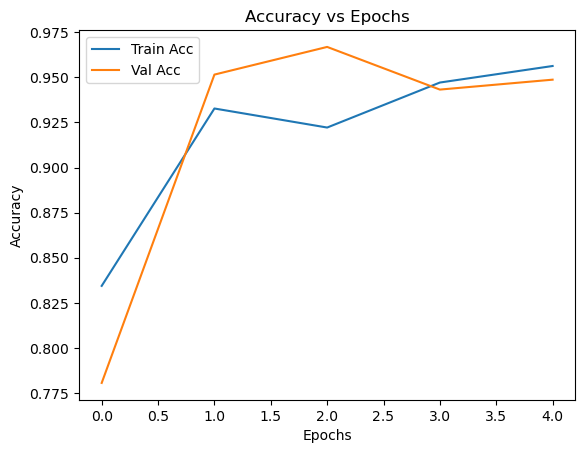

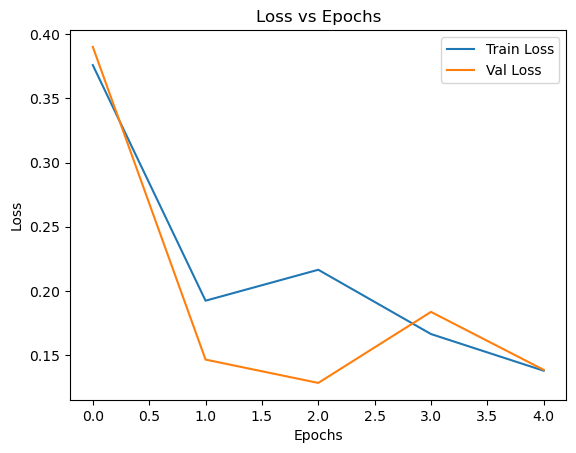

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [62]:
# Predictions
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

# EER
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fnr = 1 - tpr
eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer = interp1d(fpr, fnr)(eer_threshold)

print("🔍 Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"EER:       {eer:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
🔍 Evaluation Metrics:
Accuracy:  0.9476
Precision: 0.9254
AUC:       0.9859
EER:       0.0467

📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.91      0.94      1791
        Real       0.93      0.98      0.95      2120

    accuracy                           0.95      3911
   macro avg       0.95      0.94      0.95      3911
weighted avg       0.95      0.95      0.95      3911



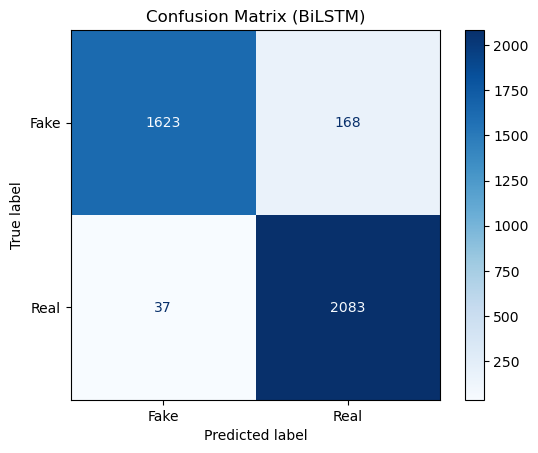

In [63]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
plt.title("Confusion Matrix (BiLSTM)")
plt.show()


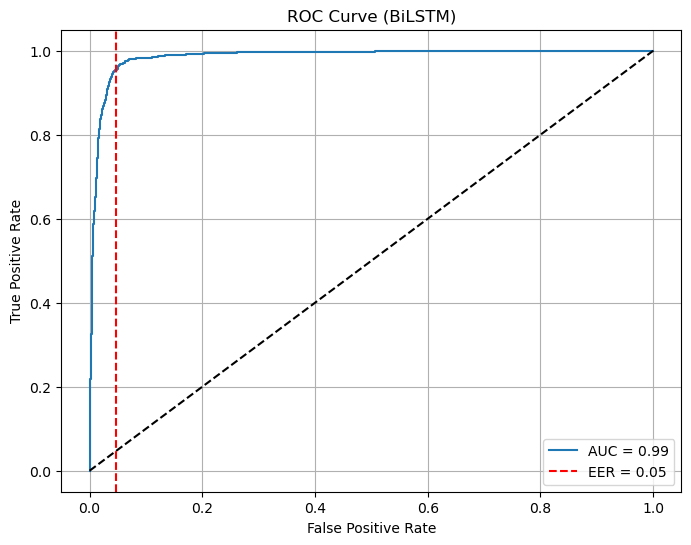

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.axvline(eer_threshold, color='red', linestyle='--', label=f"EER = {eer:.2f}")
plt.title("ROC Curve (BiLSTM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
